In [176]:
import copy 
import os 
import shutil
import itertools
from collections import Counter
import json
import pickle
import pprint
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = [6, 8]

# Utility Functions 

In [177]:
##LEGACY TO BE REMOVED 
def eligible_exps(queries, e_list):
    '''Gets all experiments from e_list with the queries attributes
    param: elist: list of all posible expeirment keys 
    param: queries: list of terms which must be elements of e_list tuples'''
    ret = []
    for exp in e_list:
        flag = True
        for q in queries: 
            if q not in exp:
                flag = False
        if flag:
            ret.append(exp)
    return ret

In [222]:
def get_eligible_exps(queries, e_list):
    '''Gets all experiments from e_list with the queries attributes
    param: elist: list of all posible expeirment tuples in results d_structs 
    param: queries: list of terms which must be elements of e_list tuples
    
    Assumes that queries have same order as elist  
    '''
    ret = []
    for exp in e_list:
        assert len(exp) == len(queries)
        flag = True
        for i in range(len(queries)):
            if (queries[i] != exp[i]) and (queries[i] != 'all'):
                flag = False
        if flag:
            ret.append(exp)
            
    return ret

In [301]:
def aggregate_exps(alist, exps):
    '''Aggregate exps, a list of tuples, into a list of lists of tuples [big_exp[all_exp]]'''
    ret = {}
    for e in exps: 
        e_new = tuple([e[i] for i in range(len(e)) if i not in alist])  #get agregated index 
        try:  #Put aggregated list into dictionary 
            ret[e_new].append(e)
        except KeyError:
            ret[e_new] = [e]
    return ret.items() 

In [178]:
def norm_ctr(Ctr, n):
    '''Returns sorted list (ctr_name, p) of the n most common elements in Ctr, where p is normalized freq'''
    sort = [list(x) for x in Ctr.most_common(n)]
    norm = len(list(Ctr.elements()))
    for t in sort:
        t[1] = t[1]/norm
    
    return sort 

def add_slist(s1, s2):
    'For all common-keyed tuples in s1-2, add prob values. For new ones, add to returned list'
    s1_keys = [x[0] for x in s1]
    ret = copy.deepcopy(s1)
    
    for t in s2: 
        if t[0] not in s1_keys:
            ret.append(t)
        else:
            for cp in ret:
                if cp[0] == t[0]:
                    cp[1] += t[1]
    return ret
    
def scale_slist(s, nf):
    for t in s:
        t[1] = t[1]/nf
    return s

def sqrt_slist(s):
    for t in s:
        t[1] = np.sqrt(t[1])
    return s

def sqdiff_slist(s1, means):
    '''For every value of m, find the (m, (s-m)^2)'''
    s1_keys = [s[0] for s in s1]
    ret = []
    
    for m in means:
        if m[0] in s1_keys: 
            for s in s1:
                if m[0] == s[0]:
                    ret.append([m[0], ((m[1]-s[1])**2)])
        else:
            ret.append([m[0], (m[1]**2)])
    
    return ret

def mean_slist(all_exps, results):
    '''For all specified experiments, find the list of (CPid, prob) for each and average them
    param: all_exps -- 
    '''
    cp = []
    norm = len(all_exps)
    for exp in all_exps: 
        cp = add_slist(cp, norm_ctr(results[exp], None)) #Add the causal predictors to each 
    scaled = scale_slist(cp, norm)
    return sorted(scaled, key=lambda x:x[1], reverse=True)
        

def var_slist(all_exps, results):
    cp = []
    norm = len(all_exps)
    means = mean_slist(all_exps, results)
    
    for exp in all_exps: 
        cp = add_slist(cp, sqdiff_slist(norm_ctr(results[exp], None), means))

    cp = sqrt_slist(scale_slist(cp, norm))
    
    #Sort in same order as means 
    ret = []
    for m in means:
        for e in cp:
            if m[0] == e[0]:
                ret.append(e)
    
    return ret


## Plotting

In [267]:
FEATENG_IND = 0
SEED_IND = 1
DATASET_IND = 2
ENV_IND = 3
REDDATA_IND = 4 

In [278]:
colours = ['b', 'g', 'r', 'c', 'k', 'm', 'y', 'w']
def num_delems(d):
    '''Get number of elements in dictionary with list values'''
    tot = 0 
    for l in d.keys():
        tot += len(d[l])
    return tot

def make_subplots(nplots, ncols, scaling):
    fig, axes = plt.subplots(nrows=int(nplots/ncols) + 1, ncols=NCOLS, figsize=(NCOLS*scaling[0], NROWS*scaling[1]))
    return fig, axes
    

# Load Data

In [179]:
res_dirs = os.path.join(os.getcwd(), 'processed_results')
print(os.listdir(res_dirs))

['.DS_Store', '0505_reddata1-20t_full', 'old']


In [180]:
accepted_dirs = ['0505_reddata1-20t_full']

In [181]:
results = {}
for r in os.listdir(res_dirs):
    if r in accepted_dirs:
        pdir = os.path.join(res_dirs, r)
        info = r.split('_')[2]
        
        results[info] =  {}
        results[info]['x_axis'] = pickle.load(open(os.path.join(pdir, 'x_axis'), 'rb'))
        results[info]['y_axis'] = pickle.load(open(os.path.join(pdir, 'y_axis'), 'rb'))
        results[info]['CPid_results'] = pickle.load(open(os.path.join(pdir, 'CPid_results'), 'rb'))
        
print(results.keys())

dict_keys(['full'])


# ALPHA SENSITIVITY PLOTS

##Regular

In [284]:
plotting__alpha_sensitivity = ['full']
feateng = ['12']
seed = ['784']
dataset = ['adult']
environment = ['all']
reddata = ['1000']
avail_exps = feateng + seed + dataset + environment + reddata

desired_exps = {}
for dsetres in plotting__alpha_sensitivity:
    desired_exps[dsetres] = get_eligible_exps(avail_exps, results[dsetres]['CPid_results'].keys())

#Sort desired exps in plotting order 
for dsetres in desired_exps.keys():
    desired_exps[dsetres] = sorted(desired_exps[dsetres], key=lambda x :x[ENV_IND])
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


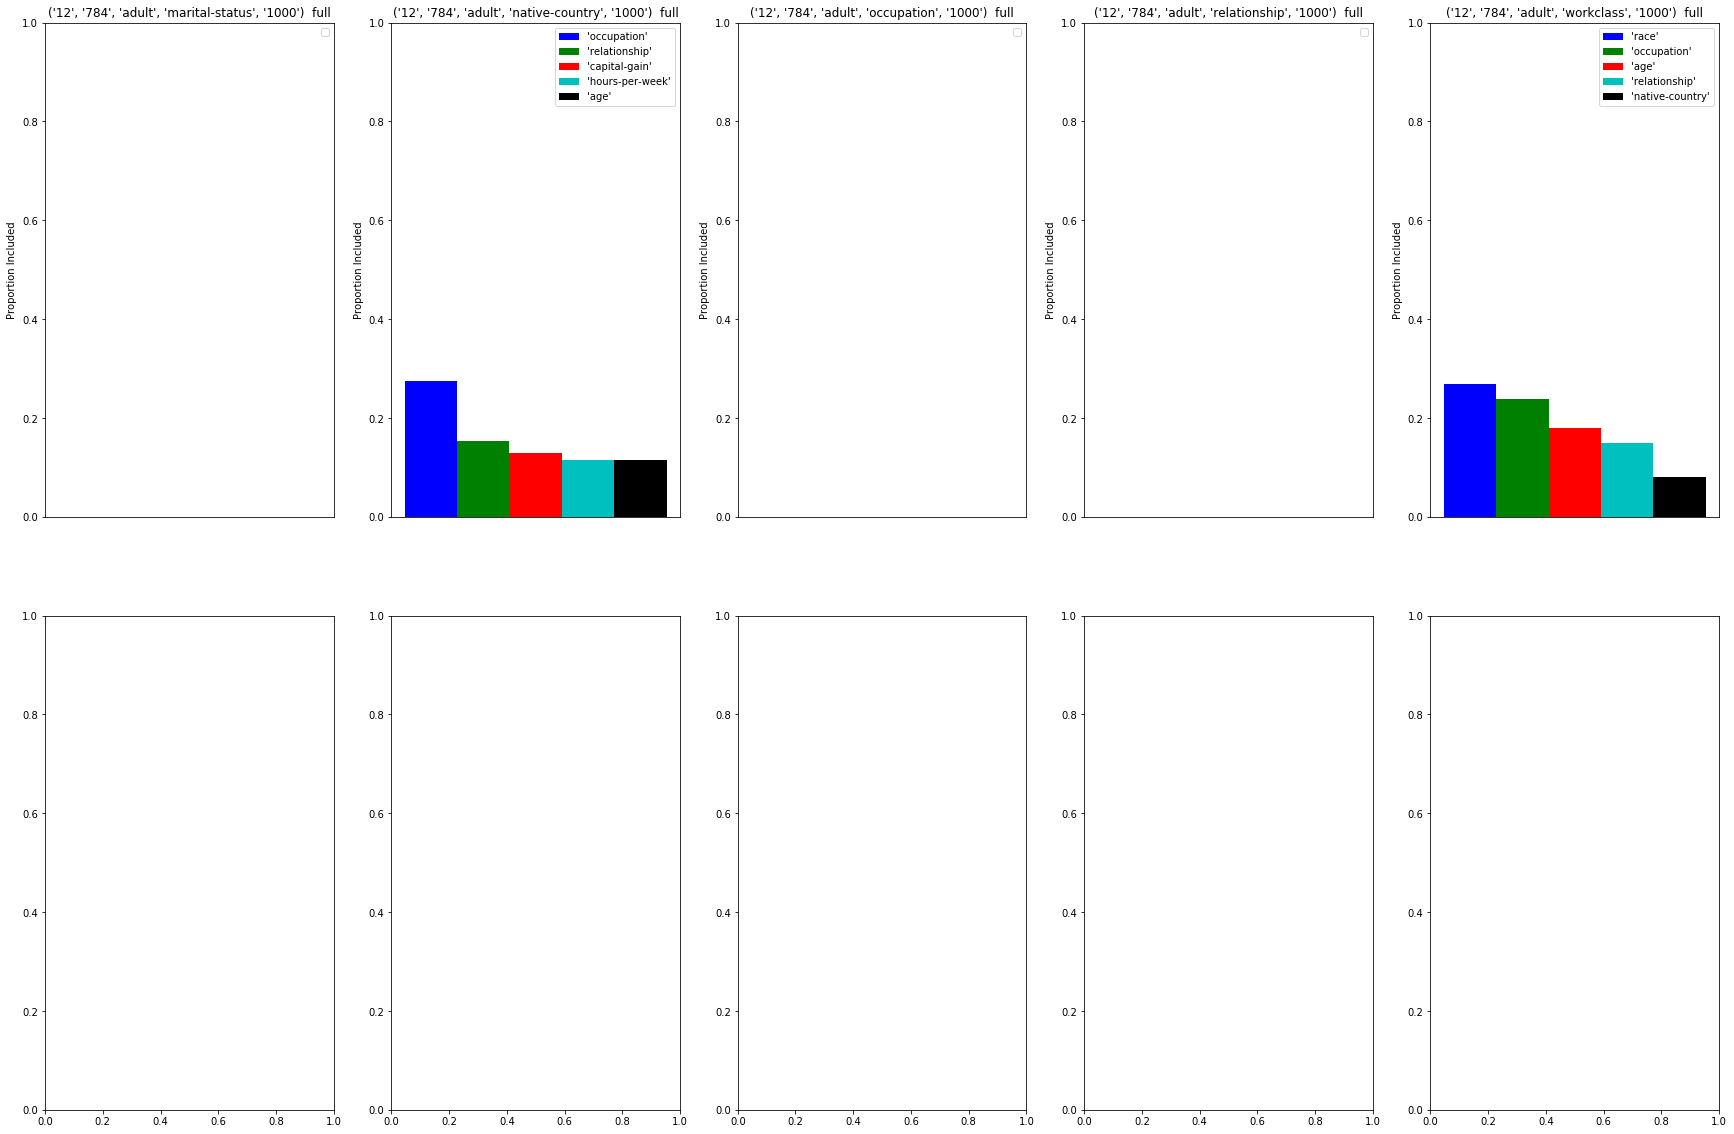

In [285]:
if plotting__alpha_sensitivity: 
    
    #plotting stuff
    NCOLS = 5
    nplts = num_delems(desired_exps)
    fig, axes = make_subplots(nplts, NCOLS, (6,2))
    pidx = 0  #plotting index to deal with changes
    
    #Iterate through each dsetres, then exp for that dsetres
    for dsetres in desired_exps:
        if pidx > 0: pidx = pidx + (NCOLS - pidx%NCOLS)
        for exp in desired_exps[dsetres]:
            assert type(exp) == tuple  #Check to make sure not aggregates
            avg_sort_pcp_sens = norm_ctr(results[dsetres]['CPid_results'][exp], 5)

            labels = []
            bars = []
            for d in range(min(8,len(avg_sort_pcp_sens))):
                labels.append(avg_sort_pcp_sens[d][0])
                bars.append(avg_sort_pcp_sens[d][1])

            X = 0 
            width = 0.05  # the width of the bars

            axes[int((pidx)/NCOLS), (pidx)%NCOLS].set_title('{}  {}'.format(exp, dsetres))  #, pad=30)
            if (i%NCOLS) == 0:
                axes[int(pidx/NCOLS), pidx%NCOLS].set_ylabel('Proportion Included') #, fontsize=32)
                axes[int(pidx/NCOLS), pidx%NCOLS].yaxis.labelpad = 5
            axes[int(pidx/NCOLS), pidx%NCOLS].set_ylim(0,1)
            axes[int(pidx/NCOLS), pidx%NCOLS].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the 

            for d in range(len(labels)):
                axes[int(pidx/NCOLS), pidx%NCOLS].bar(X + (d*width), bars[d], color = colours[d], \
                                        width = width, label=labels[d])
            axes[int(pidx/NCOLS), pidx%NCOLS].legend(loc='upper right')  #, prop={'size':30}) 
            
            pidx += 1  #Increment plotting counter

    plt.show()

##Aggregate Random Seeds

In [332]:
plotting__alpha_sensitivity = ['full']
feateng = ['12']
seed = ['all']
dataset = ['adult']
environment = ['all']
reddata = ['all']
avail_exps = feateng + seed + dataset + environment + reddata

#get all the exps you wish to plot 
desired_exps_agg = {}
for dsetres in plotting__alpha_sensitivity:
    desired_exps_agg[dsetres] = get_eligible_exps(avail_exps, results[dsetres]['CPid_results'].keys())

#Now aggregate the existing list into different dictionaries 
agg_list = [SEED_IND]
for dsetres in plotting__alpha_sensitivity:
    desired_exps_agg[dsetres] = aggregate_exps(agg_list,  desired_exps_agg[dsetres])

#Now sort the exps 
if SEED_IND in agg_list:
    for dsetres in plotting__alpha_sensitivity:
        desired_exps_agg[dsetres] = sorted(desired_exps_agg[dsetres], key=lambda x :(x[0][ENV_IND-1], int(x[0][REDDATA_IND-1])))

In [333]:
print([x[0] for x in desired_exps_agg['full']])

[('12', 'adult', 'marital-status', '1000'), ('12', 'adult', 'marital-status', '3000'), ('12', 'adult', 'marital-status', '5000'), ('12', 'adult', 'marital-status', '7500'), ('12', 'adult', 'marital-status', '10000'), ('12', 'adult', 'marital-status', '12500'), ('12', 'adult', 'marital-status', '15000'), ('12', 'adult', 'marital-status', '17500'), ('12', 'adult', 'marital-status', '20000'), ('12', 'adult', 'native-country', '1000'), ('12', 'adult', 'native-country', '3000'), ('12', 'adult', 'native-country', '5000'), ('12', 'adult', 'native-country', '7500'), ('12', 'adult', 'native-country', '10000'), ('12', 'adult', 'native-country', '12500'), ('12', 'adult', 'native-country', '15000'), ('12', 'adult', 'native-country', '17500'), ('12', 'adult', 'native-country', '20000'), ('12', 'adult', 'occupation', '1000'), ('12', 'adult', 'occupation', '3000'), ('12', 'adult', 'occupation', '5000'), ('12', 'adult', 'occupation', '7500'), ('12', 'adult', 'occupation', '10000'), ('12', 'adult', 'oc

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles wi

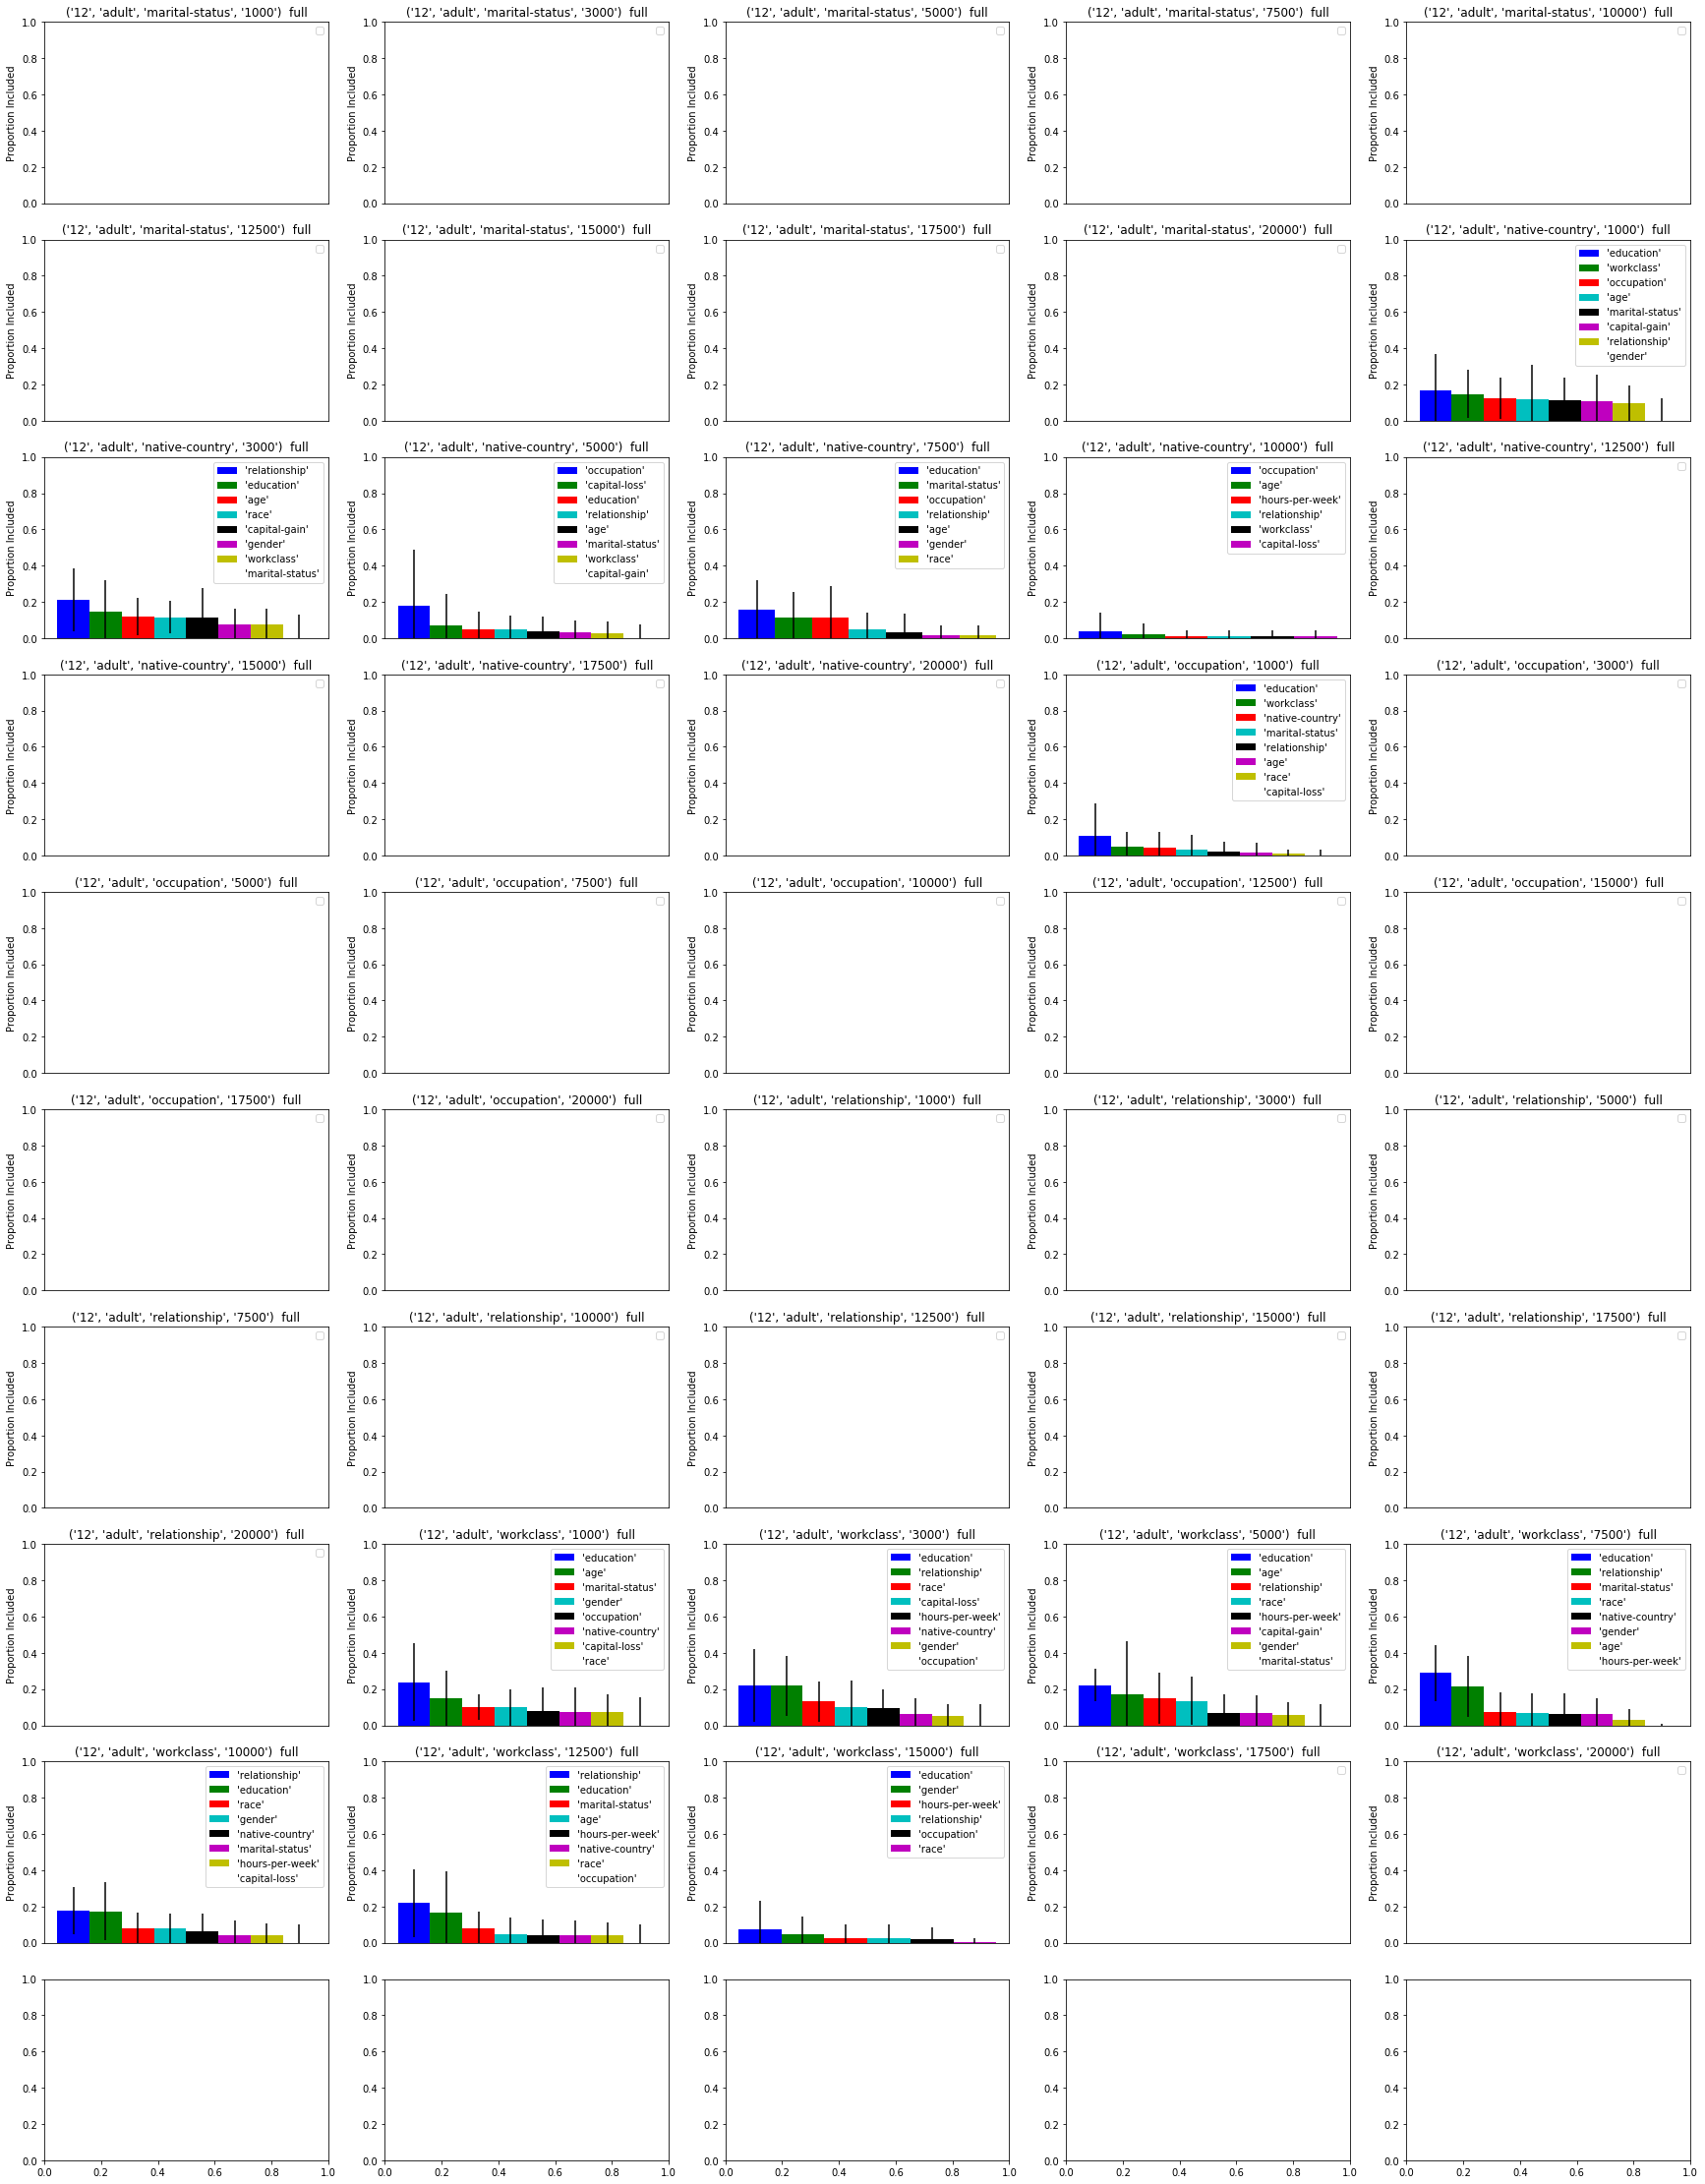

In [334]:
if plotting__alpha_sensitivity: 
    
    #plotting stuff
    NCOLS = 5
    nplts = num_delems(desired_exps_agg)
    fig, axes = make_subplots(nplts, NCOLS, (6,4))
    pidx = 0  #plotting index to deal with changes
    
    #Iterate through each dsetres, then exp for that dsetres
    for dsetres in desired_exps:
        if pidx > 0: pidx = pidx + (NCOLS - pidx%NCOLS)
        for bexp, aexps in desired_exps_agg[dsetres]:
            avg_sort_pcp_sens = mean_slist(aexps, results[dsetres]['CPid_results'])
            errors = var_slist(aexps, results[dsetres]['CPid_results'])

            labels = []
            bars = []
            errors_plt = []
            for d in range(min(8,len(avg_sort_pcp_sens))):
                labels.append(avg_sort_pcp_sens[d][0])
                bars.append(avg_sort_pcp_sens[d][1])
                errors_plt.append(errors[d][1])

            X = 0 
            width = 0.05  # the width of the bars

            axes[int((pidx)/NCOLS), (pidx)%NCOLS].set_title('{}  {}'.format(bexp, dsetres))  #, pad=30)
            if (i%NCOLS) == 0:
                axes[int(pidx/NCOLS), pidx%NCOLS].set_ylabel('Proportion Included') #, fontsize=32)
                axes[int(pidx/NCOLS), pidx%NCOLS].yaxis.labelpad = 5
            axes[int(pidx/NCOLS), pidx%NCOLS].set_ylim(0,1)
            axes[int(pidx/NCOLS), pidx%NCOLS].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the 

            for d in range(len(labels)):
                axes[int(pidx/NCOLS), pidx%NCOLS].bar(X + (d*width), bars[d], color = colours[d], \
                                        width = width, label=labels[d], yerr=errors_plt[d])
            axes[int(pidx/NCOLS), pidx%NCOLS].legend(loc='upper right')  #, prop={'size':30}) 
            
            pidx += 1  #Increment plotting counter

    plt.show()

# Confusion Matrix

# Number PCPS Accepted

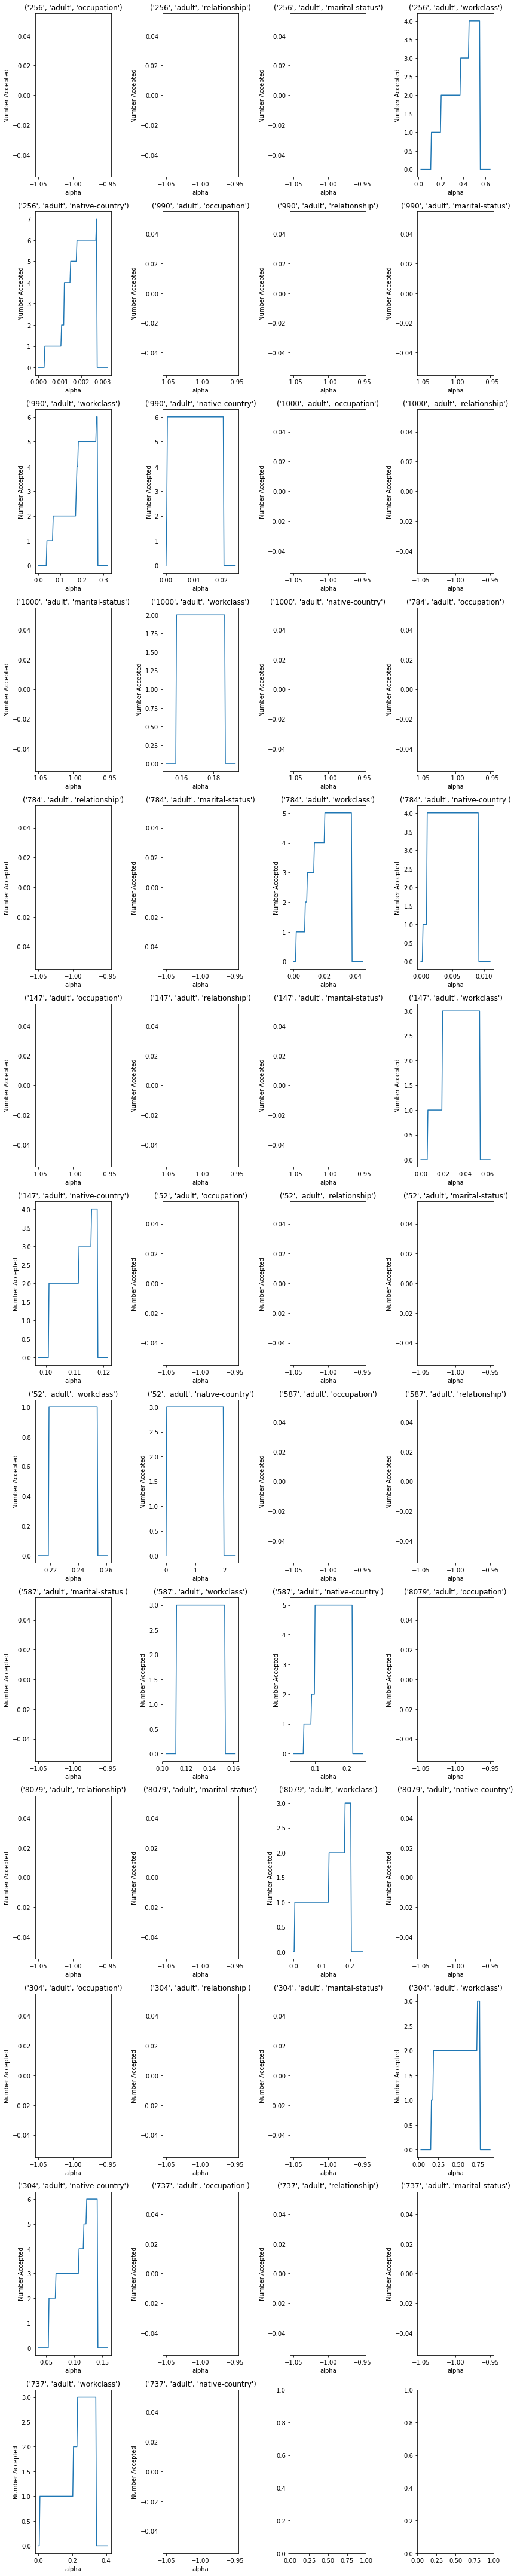

In [154]:
plotting__num_pcps = ['full']
NCOLS = 4

if len(plotting__num_pcps) > 0:
    make_subplots(NCOLS)
    
    NCOLS = 4
    NROWS = int((len(plotting__num_pcps) * 50/NCOLS))
    fig, axes = plt.subplots(NROWS + 1, ncols=NCOLS, figsize=(NCOLS*3, NROWS*5))
    i = 0

    for info in plotting__num_pcps:
        x_axis = results[info]['x_axis']
        y_axis = results[info]['y_axis']

        #Now do plotting
        for exp in x_axis.keys():  #Assume x_axis, y_axis keys are the same 
            axes[int(i/4), i%4].plot(x_axis[exp], y_axis[exp])
            axes[int(i/4), i%4].set_title(exp)
            axes[int(i/4), i%4].set_ylabel('Number Accepted')
            axes[int(i/4), i%4].set_xlabel('alpha')
            i += 1

    plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    plt.tight_layout()
    plt.show()


In [142]:
def consmat_dict_2_array(cmat, e_order):
    '''Convert dictionary with len(envs)^2 (env, env) tuples into numpy array with envs ordered as in e_order'''
    assert len(cmat.keys()) == len(e_order) ** 2
    #Create dictionary of passed environment list 
    od = {}
    for i, e1 in enumerate(e_order): 
        for j, e2 in enumerate(e_order):
            if i <= j:    
                od[(e1, e2)] = (i, j)
            
    #populate the array
    result = np.zeros([int(np.sqrt(len(cmat.keys()))), int(np.sqrt(len(cmat.keys())))])
    for epair, val in cmat.items():
        try:
            result[od[epair][0], od[epair][1]] = val
        except KeyError:
            continue
    
    return result
        

In [145]:
E_IND = 2
plotting__consistency_mat = ['1000-sample']
assert len(plotting__consistency_mat) == 1
dataset = ['adult']
environment = ['native-country', 'workclass', 'marital-status', 'occupation', 'relationship']
seed = ['1000', '8079', '52', '147', '256', '784', '990', '587', '304', '737']

for dsetres in plotting__consistency_mat:
    all_consmats = []  #consmats for all (dataset, seed) combos
    
    #Get the consistency matrix for each seed
    for big_exp in list(itertools.product(dataset, seed)):  #enumerates through each random seed 
        env_exps =  eligible_exps(big_exp, results[dsetres]['CPid_results'].keys())
        res = {}
        for i, env_1 in enumerate(env_exps):
            for j, env_2 in enumerate(env_exps):
                e1 = set([x[0] for x in norm_ctr(results[dsetres]['CPid_results'][env_1], 5)])
                e2 = set([x[0] for x in norm_ctr(results[dsetres]['CPid_results'][env_2], 5)])
                #Jaccard
                if (len(set.intersection(e1, e2)) == 0) and (len(set.union(e1, e2)) == 0):
                    res[(env_1[E_IND], env_2[E_IND])] = 1
                else:
                    res[(env_1[E_IND], env_2[E_IND])] = len(set.intersection(e1, e2))/len(set.union(e1, e2))

        all_consmats.append(consmat_dict_2_array(res, environment))

    #Compute mean, variance of consistency matrix 
    mean_consmat = (sum(all_consmats)/len(all_consmats)).round(decimals=2)
    std_consmat = np.zeros([len(environment), len(environment)])
    for cm in all_consmats:
        std_consmat += np.square((cm - mean_consmat))
    std_consmat = np.sqrt(std_consmat/len(all_consmats)).round(decimals=2)

    consmat = pd.DataFrame(mean_consmat, index=environment, columns=environment).applymap(str).apply( \
                  lambda x: x + ' +- ') + pd.DataFrame(std_consmat, index=environment, columns=environment).applymap(str)  
    consmat.style

consmat.style



,native-country,workclass,marital-status,occupation,relationship
native-country,1.0 +- 0.0,0.2 +- 0.31,0.0 +- 0.0,0.04 +- 0.09,0.0 +- 0.0
workclass,0.0 +- 0.0,1.0 +- 0.0,0.0 +- 0.0,0.07 +- 0.11,0.0 +- 0.0
marital-status,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,0.7 +- 0.46,1.0 +- 0.0
occupation,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0,0.7 +- 0.46
relationship,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,0.0 +- 0.0,1.0 +- 0.0
